In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [3]:
img1 = cv2.imread('../eigenerAnsatz/bildverband2/DJI_0289.JPG')
img2 = cv2.imread('../eigenerAnsatz/bildverband2/DJI_0288.JPG')

In [4]:
sift = cv2.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(
    cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY), None)
kp2, des2 = sift.detectAndCompute(
    cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY), None)

In [70]:
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=100)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

# Apply Lowe's SIFT matching ratio test
good = []
for m, n in matches:
        if m.distance < 0.8 * n.distance:
            good.append(m)

src_pts = np.asarray([kp1[m.queryIdx].pt for m in good])
dst_pts = np.asarray([kp2[m.trainIdx].pt for m in good])

# Constrain matches to fit homography
retval, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 100.0)
mask = mask.ravel()

# We select only inlier points
pts1 = src_pts[mask == 1]
pts2 = dst_pts[mask == 1]

/tmp/ipykernel_24488/1769288697.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


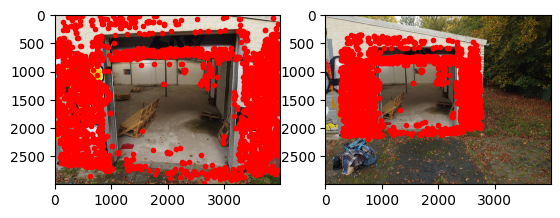

In [17]:
fig, ax = plt.subplots(1, 2)
ax[0].autoscale_view('tight')
ax[0].imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
ax[0].plot(pts1.T[0], pts1.T[1], 'r.')
ax[1].autoscale_view('tight')
ax[1].imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
ax[1].plot(pts2.T[0], pts2.T[1], 'r.')
fig.show()

In [8]:
height, width, ch = img1.shape
K = np.array([  # for dino
    [3030.65, 0, width / 2-6],
    [0, 3030.65, height / 2+17],
    [0, 0, 1]])

In [71]:
E, mask = cv2.findEssentialMat(pts1, pts2, K)
E

array([[-0.00076653, -0.69358012, -0.13758717],
       [ 0.68145853,  0.02580074, -0.1299761 ],
       [ 0.13189542,  0.00102188, -0.02594548]])

In [72]:
retval, R, t, mask = cv2.recoverPose(E,pts1, pts2, K)
R,t

(array([[ 0.98052439,  0.03717197, -0.19284752],
        [-0.03625619,  0.99930825,  0.00827694],
        [ 0.19302179, -0.00112382,  0.98119383]]),
 array([[-0.00562235],
        [-0.1900253 ],
        [ 0.98176309]]))

In [73]:
P1 = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0]])
P2 = np.hstack((R, t))
P2

array([[ 0.98052439,  0.03717197, -0.19284752, -0.00562235],
       [-0.03625619,  0.99930825,  0.00827694, -0.1900253 ],
       [ 0.19302179, -0.00112382,  0.98119383,  0.98176309]])

In [78]:
point_4d_hom = cv2.triangulatePoints(P1, P2, pts1.T, pts2.T)
point_4d_hom


array([[-0.16641143, -0.17543941, -0.18604445, ..., -0.40652112,
        -0.38229856, -0.33705214],
       [ 0.0024464 ,  0.00288735,  0.00340052, ...,  0.00819717,
         0.00753514,  0.00631279],
       [-0.6809651 , -0.67896315, -0.6765324 , ..., -0.60505432,
        -0.61494462, -0.63198744],
       [ 0.71315341,  0.71289671,  0.71251653, ...,  0.68453098,
         0.68966234,  0.6978165 ]])

In [ ]:
coords = cv2.convertPointsFromHomogeneous(point_4d_hom.T).reshape(len(pts1),3)
coords

In [63]:
point_4d = point_4d_hom / np.tile(point_4d_hom[-1, :], (4, 1))
point_3d = point_4d[:3, :].T
point_3d


array([[-0.27113979, -0.00424266, -0.94833996],
       [-0.25763231, -0.00446743, -0.95109949],
       [-0.26986601, -0.00422629, -0.94859784],
       ...,
       [-0.58339398, -0.00776841, -0.88325339],
       [-0.50807206, -0.00741016, -0.89889893],
       [-0.62841398, -0.00974508, -0.87389182]])

In [82]:
Kinv = np.linalg.inv(K)


def linear_triangulation(p1, p2, m1, m2):
    """
    Linear triangulation (Hartley ch 12.2 pg 312) to find the 3D point X
    where p1 = m1 * X and p2 = m2 * X. Solve AX = 0.
    :param p1, p2: 2D points in homo. or catesian coordinates. Shape (3 x n)
    :param m1, m2: Camera matrices associated with p1 and p2. Shape (3 x 4)
    :returns: 4 x n homogenous 3d triangulated points
    """
    num_points = p1.shape[1]
    res = np.ones((4, num_points))

    for i in range(num_points):
        A = np.asarray([
            (p1[0, i] * m1[2, :] - m1[0, :]),
            (p1[1, i] * m1[2, :] - m1[1, :]),
            (p2[0, i] * m2[2, :] - m2[0, :]),
            (p2[1, i] * m2[2, :] - m2[1, :])
        ])

        _, _, V = np.linalg.svd(A)
        X = V[-1, :4]
        res[:, i] = X / X[3]

    return res


coords = linear_triangulation(Kinv@pts1.T, Kinv@pts2.T, P1, P2)


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 2 is different from 3)

In [81]:
%matplotlib qt
fig = plt.figure()
fig.suptitle('3D reconstructed', fontsize=16)
ax = fig.add_subplot(projection='3d')
ax.plot(coords[0], coords[1], coords[2], 'r.')
ax.set_xlabel('x axis')
ax.set_ylabel('y axis')
ax.set_zlabel('z axis')
ax.view_init(elev=135, azim=90)
plt.show()


qt.qpa.wayland: Wayland does not support QWindow::requestActivate()
